Cell-1: Importing all library

In [3]:
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy




In [4]:
!pip install grad-cam  # run once

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

Cell-2: Loading datasets

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_data_dir = "/kaggle/input/dataset-bau/dataset_mymensingh"
working_dir = "/kaggle/working/rice_data"
batch_size = 32
num_classes = 6


Cell-3: Dividing dataset for train and test with 80:20 ratio

In [6]:
def split_dataset(base_dir, output_dir, train_ratio=0.8):
    if os.path.exists(output_dir):
        print("Already split.")
        return

    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(base_dir):
        full_class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(full_class_path):
            continue
        images = os.listdir(full_class_path)
        random.shuffle(images)
        train_len = int(len(images) * train_ratio)

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in images[:train_len]:
            shutil.copy(os.path.join(full_class_path, img), os.path.join(train_dir, class_name, img))
        for img in images[train_len:]:
            shutil.copy(os.path.join(full_class_path, img), os.path.join(val_dir, class_name, img))

split_dataset(base_data_dir, working_dir)


Already split.


Cell-4: Preprocessing data

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(working_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(working_dir, 'val'), transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['Bacterial_leaf_blight', 'Brown_Spot_Grain', 'Brown_Spot_Leaf', 'Rice_Blast', 'Sheath_blight', 'Sheath_rot']


Cell-5: Defining model

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=30):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        scheduler.step(val_loss)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return history


def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            running_loss += loss.item()

    val_acc = 100 * correct / len(loader.dataset)
    val_loss = running_loss / len(loader)
    return val_loss, val_acc



Cell-6: Funtion for showing loss and accuracy graph

In [9]:
def plot_history(history, title='Training Progress'):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



Cell-7: Plotting confusion matrix

In [10]:
def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(all_labels, all_preds, target_names=class_names))


Cell-8: Loading Resnet50 model and train without fintuning

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 21/21 [01:35<00:00,  4.53s/it]


Epoch 1/10 | Loss: 1.3075 | Acc: 0.53 | Val Loss: 0.7101 | Val Acc: 81.44%


100%|██████████| 21/21 [01:25<00:00,  4.06s/it]


Epoch 2/10 | Loss: 0.6530 | Acc: 0.83 | Val Loss: 0.4150 | Val Acc: 86.23%


100%|██████████| 21/21 [01:28<00:00,  4.22s/it]


Epoch 3/10 | Loss: 0.4585 | Acc: 0.86 | Val Loss: 0.3192 | Val Acc: 88.62%


100%|██████████| 21/21 [01:33<00:00,  4.45s/it]


Epoch 4/10 | Loss: 0.4081 | Acc: 0.88 | Val Loss: 0.2778 | Val Acc: 91.62%


100%|██████████| 21/21 [01:31<00:00,  4.35s/it]


Epoch 5/10 | Loss: 0.3130 | Acc: 0.93 | Val Loss: 0.2318 | Val Acc: 92.81%


100%|██████████| 21/21 [01:33<00:00,  4.46s/it]


Epoch 6/10 | Loss: 0.3102 | Acc: 0.92 | Val Loss: 0.2467 | Val Acc: 88.02%


100%|██████████| 21/21 [01:34<00:00,  4.48s/it]


Epoch 7/10 | Loss: 0.2759 | Acc: 0.93 | Val Loss: 0.2022 | Val Acc: 92.81%


100%|██████████| 21/21 [01:33<00:00,  4.47s/it]


Epoch 8/10 | Loss: 0.2504 | Acc: 0.93 | Val Loss: 0.1611 | Val Acc: 95.81%


100%|██████████| 21/21 [01:31<00:00,  4.34s/it]


Epoch 9/10 | Loss: 0.2243 | Acc: 0.94 | Val Loss: 0.1682 | Val Acc: 94.01%


100%|██████████| 21/21 [01:29<00:00,  4.25s/it]


Epoch 10/10 | Loss: 0.2050 | Acc: 0.94 | Val Loss: 0.1561 | Val Acc: 95.81%


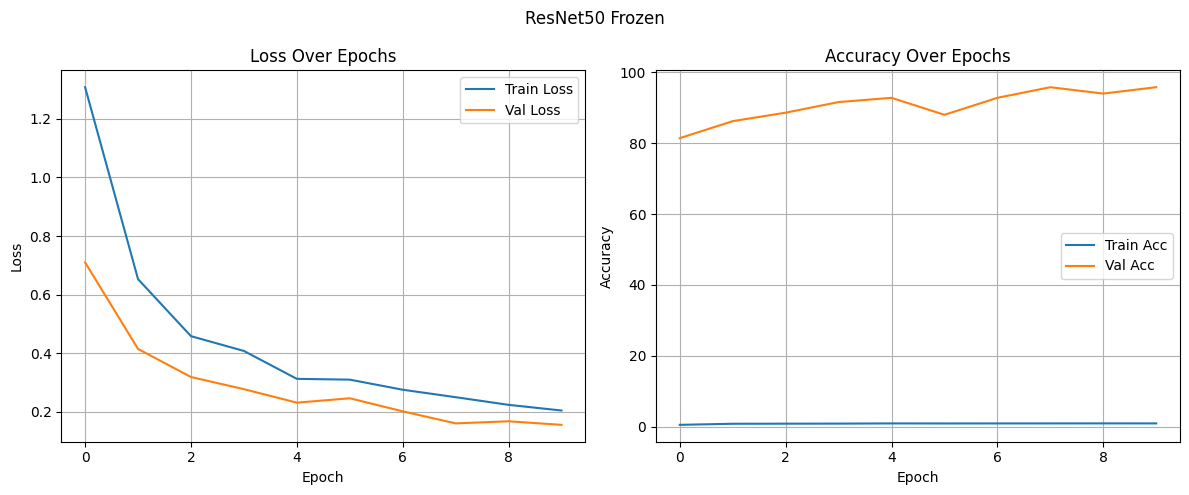

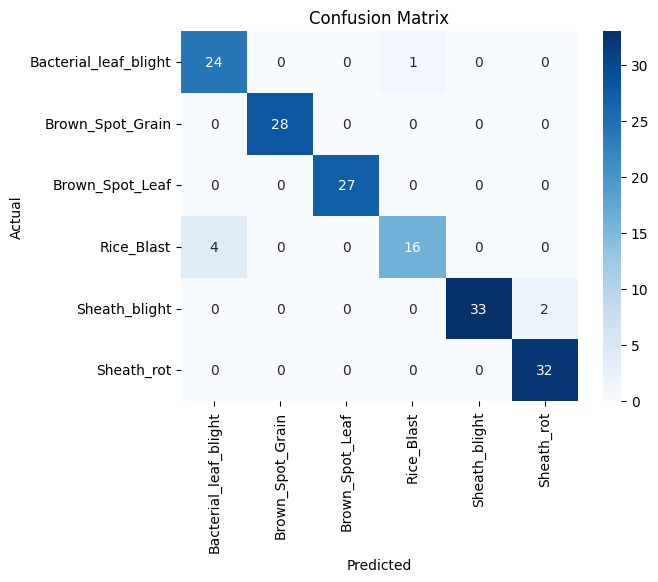

                       precision    recall  f1-score   support

Bacterial_leaf_blight       0.86      0.96      0.91        25
     Brown_Spot_Grain       1.00      1.00      1.00        28
      Brown_Spot_Leaf       1.00      1.00      1.00        27
           Rice_Blast       0.94      0.80      0.86        20
        Sheath_blight       1.00      0.94      0.97        35
           Sheath_rot       0.94      1.00      0.97        32

             accuracy                           0.96       167
            macro avg       0.96      0.95      0.95       167
         weighted avg       0.96      0.96      0.96       167



In [11]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters(): param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)  # 🔧 ADD THIS LINE


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)
resnet_history = train_model(resnet, criterion, optimizer, train_loader, val_loader, epochs=10)
plot_history(resnet_history, 'ResNet50 Frozen')
plot_confusion_matrix(resnet, val_loader, class_names)
torch.save(resnet.state_dict(), "resnet_frozen.pth")


Cell-9: Training Resnet50 model after fintuning

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 21/21 [01:40<00:00,  4.78s/it]


Epoch 1/10 | Loss: 0.1814 | Acc: 0.96 | Val Loss: 0.0904 | Val Acc: 97.60%


100%|██████████| 21/21 [01:38<00:00,  4.71s/it]


Epoch 2/10 | Loss: 0.1187 | Acc: 0.97 | Val Loss: 0.0624 | Val Acc: 98.20%


100%|██████████| 21/21 [01:40<00:00,  4.76s/it]


Epoch 3/10 | Loss: 0.1335 | Acc: 0.96 | Val Loss: 0.0485 | Val Acc: 99.40%


100%|██████████| 21/21 [01:40<00:00,  4.76s/it]


Epoch 4/10 | Loss: 0.0998 | Acc: 0.98 | Val Loss: 0.0384 | Val Acc: 99.40%


100%|██████████| 21/21 [01:39<00:00,  4.72s/it]


Epoch 5/10 | Loss: 0.0825 | Acc: 0.98 | Val Loss: 0.0274 | Val Acc: 100.00%


100%|██████████| 21/21 [01:32<00:00,  4.43s/it]


Epoch 6/10 | Loss: 0.0806 | Acc: 0.98 | Val Loss: 0.0192 | Val Acc: 100.00%


100%|██████████| 21/21 [01:40<00:00,  4.78s/it]


Epoch 7/10 | Loss: 0.0845 | Acc: 0.97 | Val Loss: 0.0202 | Val Acc: 100.00%


100%|██████████| 21/21 [01:38<00:00,  4.68s/it]


Epoch 8/10 | Loss: 0.0668 | Acc: 0.98 | Val Loss: 0.0141 | Val Acc: 100.00%


100%|██████████| 21/21 [01:39<00:00,  4.73s/it]


Epoch 9/10 | Loss: 0.0475 | Acc: 0.99 | Val Loss: 0.0140 | Val Acc: 100.00%


100%|██████████| 21/21 [01:40<00:00,  4.80s/it]


Epoch 10/10 | Loss: 0.0561 | Acc: 0.98 | Val Loss: 0.0116 | Val Acc: 100.00%


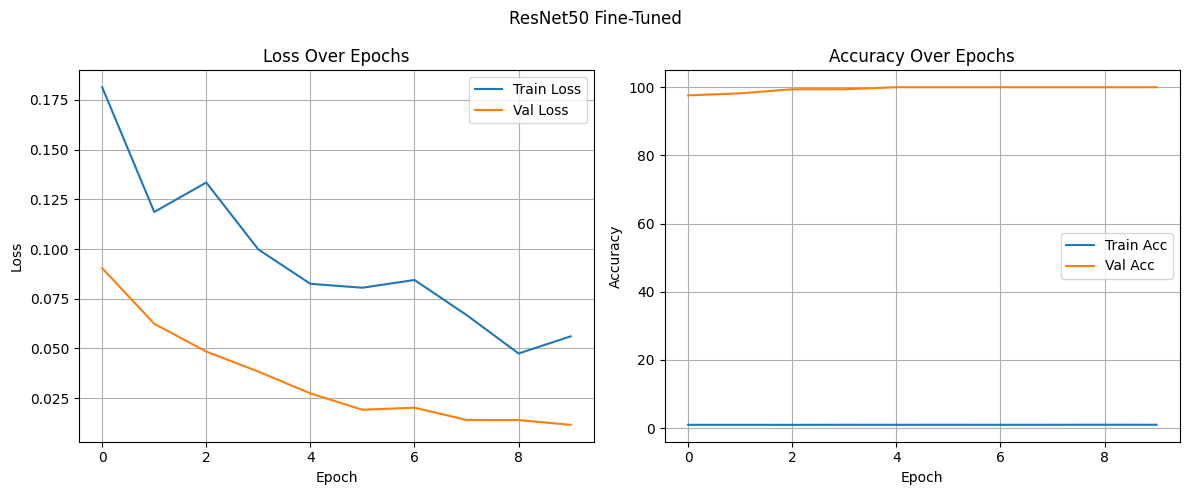

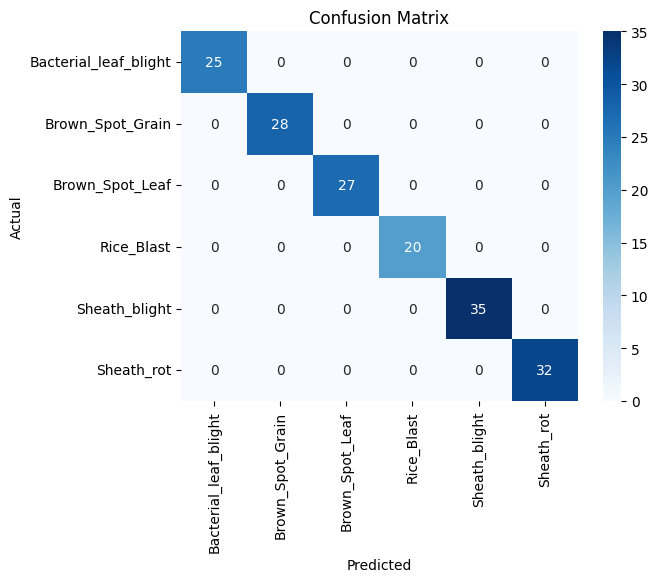

                       precision    recall  f1-score   support

Bacterial_leaf_blight       1.00      1.00      1.00        25
     Brown_Spot_Grain       1.00      1.00      1.00        28
      Brown_Spot_Leaf       1.00      1.00      1.00        27
           Rice_Blast       1.00      1.00      1.00        20
        Sheath_blight       1.00      1.00      1.00        35
           Sheath_rot       1.00      1.00      1.00        32

             accuracy                           1.00       167
            macro avg       1.00      1.00      1.00       167
         weighted avg       1.00      1.00      1.00       167



In [12]:
for param in resnet.parameters(): 
    param.requires_grad = True
resnet = resnet.to(device)
optimizer = optim.Adam(resnet.parameters(), lr=1e-5)
resnet_ft_history = train_model(resnet, criterion, optimizer, train_loader, val_loader, epochs=10)
plot_history(resnet_ft_history, 'ResNet50 Fine-Tuned')
plot_confusion_matrix(resnet, val_loader, class_names)
torch.save(resnet.state_dict(), "resnet_finetuned.pth")


Cell-10: Loading efficientNet model and train without fintuning

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr

Epoch 1/10 | Loss: 1.2856 | Acc: 0.61 | Val Loss: 0.8808 | Val Acc: 72.46%


100%|██████████| 21/21 [01:32<00:00,  4.39s/it]


Epoch 2/10 | Loss: 0.7351 | Acc: 0.83 | Val Loss: 0.5191 | Val Acc: 89.22%


100%|██████████| 21/21 [01:29<00:00,  4.26s/it]


Epoch 3/10 | Loss: 0.5558 | Acc: 0.86 | Val Loss: 0.3852 | Val Acc: 95.21%


100%|██████████| 21/21 [01:30<00:00,  4.32s/it]


Epoch 4/10 | Loss: 0.4336 | Acc: 0.90 | Val Loss: 0.3069 | Val Acc: 92.81%


100%|██████████| 21/21 [01:32<00:00,  4.38s/it]


Epoch 5/10 | Loss: 0.4007 | Acc: 0.89 | Val Loss: 0.2526 | Val Acc: 97.60%


100%|██████████| 21/21 [01:31<00:00,  4.36s/it]


Epoch 6/10 | Loss: 0.3337 | Acc: 0.91 | Val Loss: 0.2200 | Val Acc: 97.01%


100%|██████████| 21/21 [01:29<00:00,  4.24s/it]


Epoch 7/10 | Loss: 0.3012 | Acc: 0.93 | Val Loss: 0.2020 | Val Acc: 97.60%


100%|██████████| 21/21 [01:27<00:00,  4.16s/it]


Epoch 8/10 | Loss: 0.2800 | Acc: 0.91 | Val Loss: 0.1854 | Val Acc: 97.01%


100%|██████████| 21/21 [01:29<00:00,  4.28s/it]


Epoch 9/10 | Loss: 0.2573 | Acc: 0.93 | Val Loss: 0.1542 | Val Acc: 98.80%


100%|██████████| 21/21 [01:32<00:00,  4.39s/it]


Epoch 10/10 | Loss: 0.3036 | Acc: 0.92 | Val Loss: 0.1500 | Val Acc: 97.01%


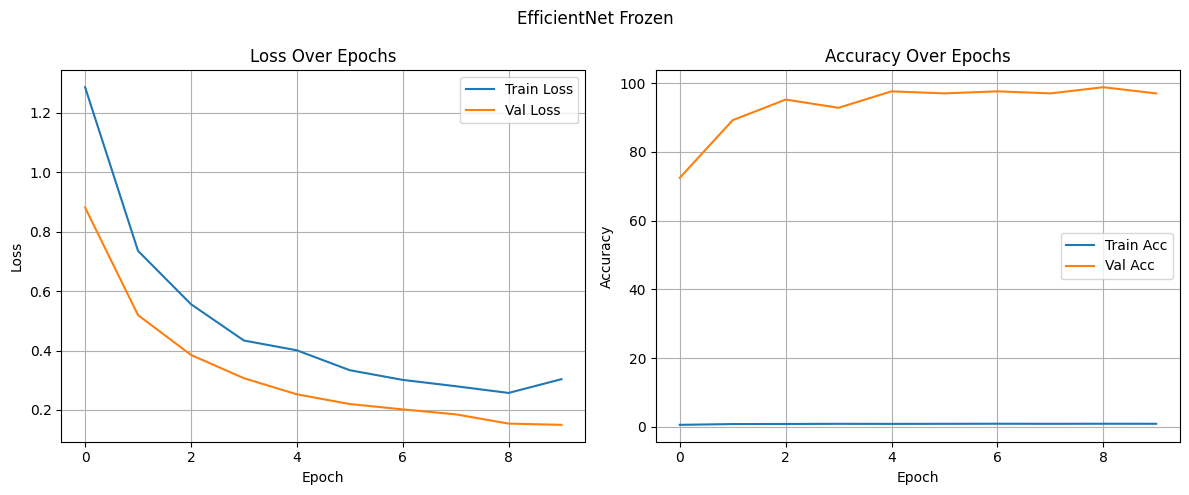

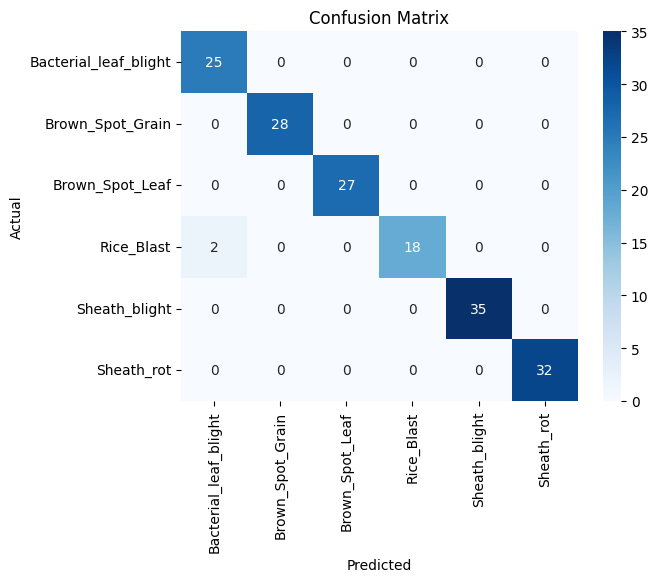

                       precision    recall  f1-score   support

Bacterial_leaf_blight       0.93      1.00      0.96        25
     Brown_Spot_Grain       1.00      1.00      1.00        28
      Brown_Spot_Leaf       1.00      1.00      1.00        27
           Rice_Blast       1.00      0.90      0.95        20
        Sheath_blight       1.00      1.00      1.00        35
           Sheath_rot       1.00      1.00      1.00        32

             accuracy                           0.99       167
            macro avg       0.99      0.98      0.98       167
         weighted avg       0.99      0.99      0.99       167



In [13]:
effnet = models.efficientnet_b0(pretrained=True)
for param in effnet.parameters(): param.requires_grad = False
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, num_classes)
effnet = effnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet.classifier[1].parameters(), lr=0.001)
effnet_history = train_model(effnet, criterion, optimizer, train_loader, val_loader, epochs=10)
plot_history(effnet_history, 'EfficientNet Frozen')
plot_confusion_matrix(effnet, val_loader, class_names)
torch.save(effnet.state_dict(), "effnet_frozen.pth")


Cell-11: Training efficientNet model after fintuning

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 21/21 [01:09<00:00,  3.30s/it]


Epoch 1/10 | Loss: 0.2651 | Acc: 0.92 | Val Loss: 0.1400 | Val Acc: 98.80%


100%|██████████| 21/21 [01:09<00:00,  3.31s/it]


Epoch 2/10 | Loss: 0.2367 | Acc: 0.95 | Val Loss: 0.1330 | Val Acc: 98.80%


100%|██████████| 21/21 [01:09<00:00,  3.31s/it]


Epoch 3/10 | Loss: 0.2247 | Acc: 0.95 | Val Loss: 0.1146 | Val Acc: 98.80%


100%|██████████| 21/21 [01:08<00:00,  3.26s/it]


Epoch 4/10 | Loss: 0.2221 | Acc: 0.93 | Val Loss: 0.1027 | Val Acc: 99.40%


100%|██████████| 21/21 [01:09<00:00,  3.29s/it]


Epoch 5/10 | Loss: 0.2187 | Acc: 0.94 | Val Loss: 0.1040 | Val Acc: 98.80%


100%|██████████| 21/21 [01:08<00:00,  3.25s/it]


Epoch 6/10 | Loss: 0.1766 | Acc: 0.96 | Val Loss: 0.0914 | Val Acc: 99.40%


100%|██████████| 21/21 [01:08<00:00,  3.26s/it]


Epoch 7/10 | Loss: 0.1924 | Acc: 0.94 | Val Loss: 0.0855 | Val Acc: 99.40%


100%|██████████| 21/21 [01:08<00:00,  3.28s/it]


Epoch 8/10 | Loss: 0.1647 | Acc: 0.96 | Val Loss: 0.0764 | Val Acc: 99.40%


100%|██████████| 21/21 [01:08<00:00,  3.27s/it]


Epoch 9/10 | Loss: 0.1481 | Acc: 0.97 | Val Loss: 0.0685 | Val Acc: 99.40%


100%|██████████| 21/21 [01:08<00:00,  3.28s/it]


Epoch 10/10 | Loss: 0.1871 | Acc: 0.95 | Val Loss: 0.0713 | Val Acc: 99.40%


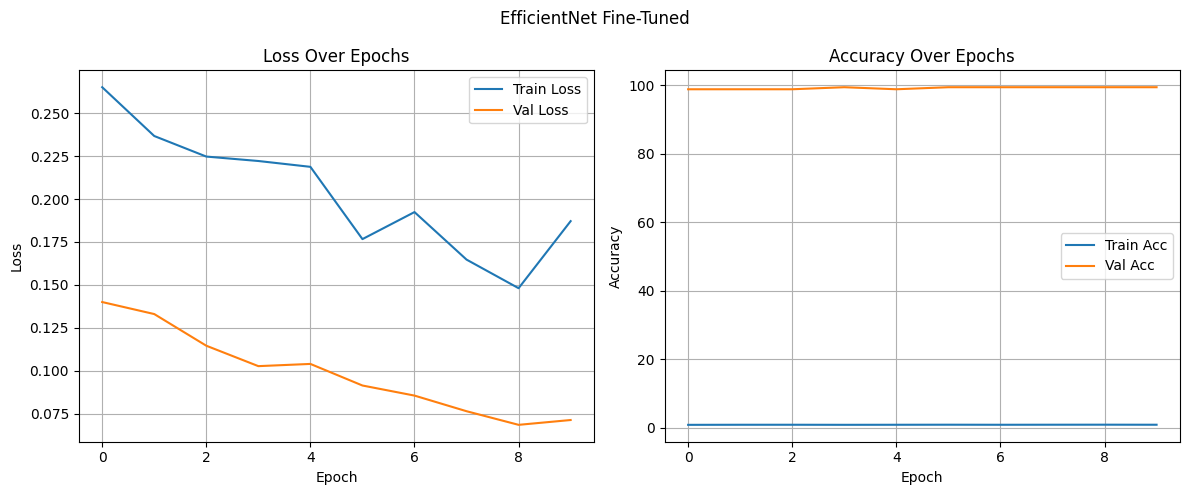

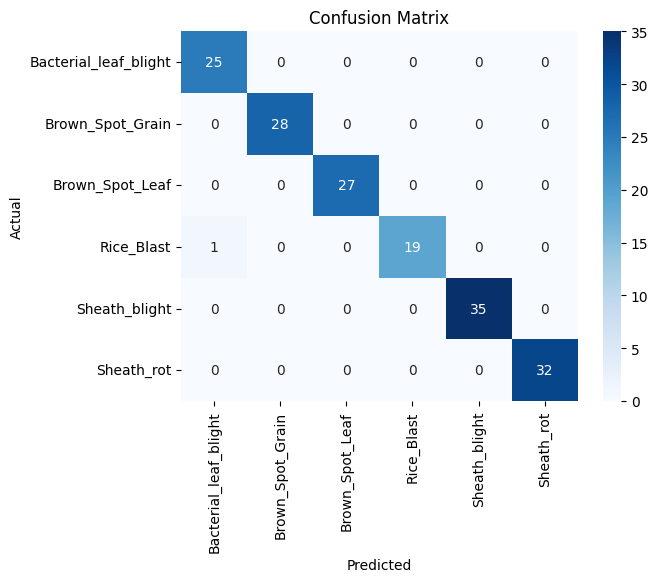

                       precision    recall  f1-score   support

Bacterial_leaf_blight       0.96      1.00      0.98        25
     Brown_Spot_Grain       1.00      1.00      1.00        28
      Brown_Spot_Leaf       1.00      1.00      1.00        27
           Rice_Blast       1.00      0.95      0.97        20
        Sheath_blight       1.00      1.00      1.00        35
           Sheath_rot       1.00      1.00      1.00        32

             accuracy                           0.99       167
            macro avg       0.99      0.99      0.99       167
         weighted avg       0.99      0.99      0.99       167



In [14]:
for param in effnet.parameters(): 
    param.requires_grad = True
effnet = effnet.to(device)
optimizer = optim.Adam(effnet.parameters(), lr=1e-5)
effnet_ft_history = train_model(effnet, criterion, optimizer, train_loader, val_loader, epochs=10)
plot_history(effnet_ft_history, 'EfficientNet Fine-Tuned')
plot_confusion_matrix(effnet, val_loader, class_names)
torch.save(effnet.state_dict(), "effnet_finetuned.pth")


Cell-12: Visualizing with GRADCAM

In [15]:
def visualize_gradcam(model, image_path, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    rgb_img = np.array(image.resize((224, 224))) / 255.0
    rgb_img = np.float32(rgb_img)

    cam = GradCAM(model=model, target_layers=[model.features[-3]], use_cuda=torch.cuda.is_available())
    targets = [ClassifierOutputTarget(0)]  # target class index
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.imshow(cam_image)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.show()

Cell-13: Defining Custom CNN Model

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 21/21 [01:06<00:00,  3.18s/it]


Epoch 1/20 | Loss: 3.3844 | Acc: 0.38 | Val Loss: 1.8030 | Val Acc: 31.14%


100%|██████████| 21/21 [01:08<00:00,  3.25s/it]


Epoch 2/20 | Loss: 1.0376 | Acc: 0.58 | Val Loss: 1.1304 | Val Acc: 43.71%


100%|██████████| 21/21 [01:08<00:00,  3.27s/it]


Epoch 3/20 | Loss: 0.7819 | Acc: 0.67 | Val Loss: 0.8734 | Val Acc: 59.28%


100%|██████████| 21/21 [01:07<00:00,  3.21s/it]


Epoch 4/20 | Loss: 0.7037 | Acc: 0.70 | Val Loss: 0.8020 | Val Acc: 60.48%


100%|██████████| 21/21 [01:08<00:00,  3.26s/it]


Epoch 5/20 | Loss: 0.6489 | Acc: 0.73 | Val Loss: 1.3108 | Val Acc: 47.31%


100%|██████████| 21/21 [01:08<00:00,  3.26s/it]


Epoch 6/20 | Loss: 0.6887 | Acc: 0.72 | Val Loss: 0.8588 | Val Acc: 60.48%


100%|██████████| 21/21 [01:07<00:00,  3.20s/it]


Epoch 7/20 | Loss: 0.6272 | Acc: 0.73 | Val Loss: 0.7072 | Val Acc: 71.86%


100%|██████████| 21/21 [01:07<00:00,  3.21s/it]


Epoch 8/20 | Loss: 0.5881 | Acc: 0.77 | Val Loss: 1.0145 | Val Acc: 55.09%


100%|██████████| 21/21 [01:06<00:00,  3.18s/it]


Epoch 9/20 | Loss: 0.5947 | Acc: 0.77 | Val Loss: 1.0965 | Val Acc: 57.49%


100%|██████████| 21/21 [01:08<00:00,  3.26s/it]


Epoch 10/20 | Loss: 0.6955 | Acc: 0.73 | Val Loss: 0.8262 | Val Acc: 61.08%


100%|██████████| 21/21 [01:07<00:00,  3.20s/it]


Epoch 11/20 | Loss: 0.5745 | Acc: 0.78 | Val Loss: 0.9099 | Val Acc: 56.89%


100%|██████████| 21/21 [01:08<00:00,  3.24s/it]


Epoch 12/20 | Loss: 0.5360 | Acc: 0.77 | Val Loss: 0.6769 | Val Acc: 67.66%


100%|██████████| 21/21 [01:06<00:00,  3.18s/it]


Epoch 13/20 | Loss: 0.5189 | Acc: 0.80 | Val Loss: 1.1867 | Val Acc: 52.69%


100%|██████████| 21/21 [01:08<00:00,  3.27s/it]


Epoch 14/20 | Loss: 0.5851 | Acc: 0.79 | Val Loss: 1.0459 | Val Acc: 56.29%


100%|██████████| 21/21 [01:06<00:00,  3.19s/it]


Epoch 15/20 | Loss: 0.5363 | Acc: 0.77 | Val Loss: 0.8991 | Val Acc: 59.88%


100%|██████████| 21/21 [01:07<00:00,  3.23s/it]


Epoch 16/20 | Loss: 0.5031 | Acc: 0.79 | Val Loss: 1.2157 | Val Acc: 58.08%


100%|██████████| 21/21 [01:06<00:00,  3.17s/it]


Epoch 17/20 | Loss: 0.4955 | Acc: 0.77 | Val Loss: 1.2800 | Val Acc: 54.49%


100%|██████████| 21/21 [01:08<00:00,  3.24s/it]


Epoch 18/20 | Loss: 0.4869 | Acc: 0.83 | Val Loss: 0.9236 | Val Acc: 65.87%


100%|██████████| 21/21 [01:07<00:00,  3.20s/it]


Epoch 19/20 | Loss: 0.4807 | Acc: 0.81 | Val Loss: 0.8932 | Val Acc: 64.67%


100%|██████████| 21/21 [01:08<00:00,  3.25s/it]


Epoch 20/20 | Loss: 0.4615 | Acc: 0.82 | Val Loss: 1.1291 | Val Acc: 54.49%


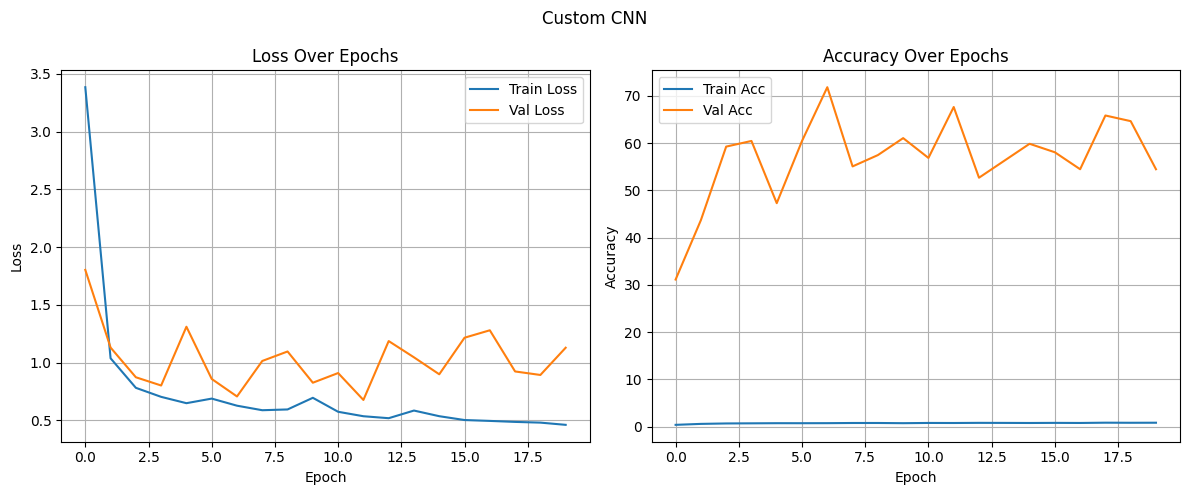

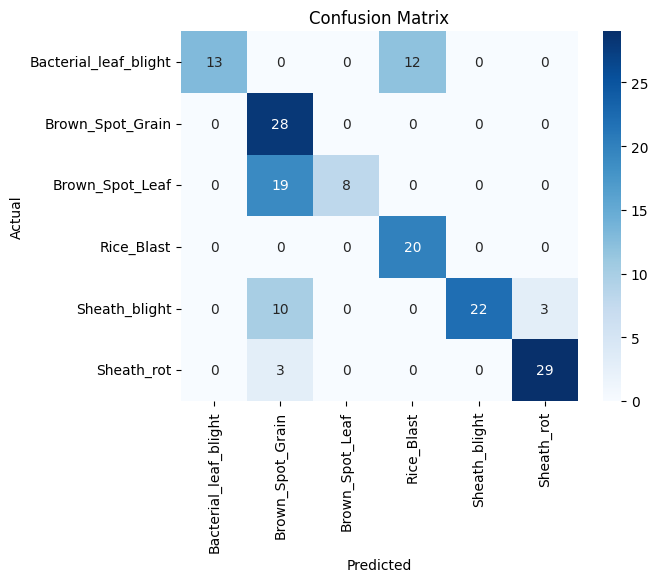

                       precision    recall  f1-score   support

Bacterial_leaf_blight       1.00      0.52      0.68        25
     Brown_Spot_Grain       0.47      1.00      0.64        28
      Brown_Spot_Leaf       1.00      0.30      0.46        27
           Rice_Blast       0.62      1.00      0.77        20
        Sheath_blight       1.00      0.63      0.77        35
           Sheath_rot       0.91      0.91      0.91        32

             accuracy                           0.72       167
            macro avg       0.83      0.73      0.70       167
         weighted avg       0.85      0.72      0.71       167



In [16]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


custom_model = CustomCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(custom_model.parameters(), lr=0.001)
optimizer = optim.Adam(
    custom_model.parameters(),
    lr=0.0001,
    betas=(0.9, 0.999),
    eps=1e-7
    # weight_decay=1e-5  # (optional) can test this
)

custom_history = train_model(custom_model, criterion, optimizer, train_loader, val_loader, epochs=20)
plot_history(custom_history, 'Custom CNN')
plot_confusion_matrix(custom_model, val_loader, class_names)
torch.save(custom_model.state_dict(), "custom_cnn.pth")


Cell-14: Defining function for prediction

In [17]:
def visualize_predictions(model, loader, class_names, n=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                img = images[i].permute(1, 2, 0).cpu().numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f"True: {class_names[labels[i]]} | Pred: {class_names[preds[i]]}")
                plt.axis("off")
                plt.show()

                shown += 1
                if shown >= n:
                    return


Cell-15: Visualize the prediction

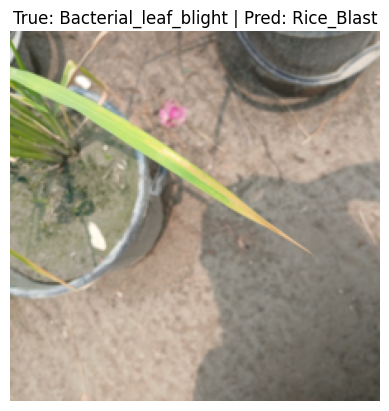

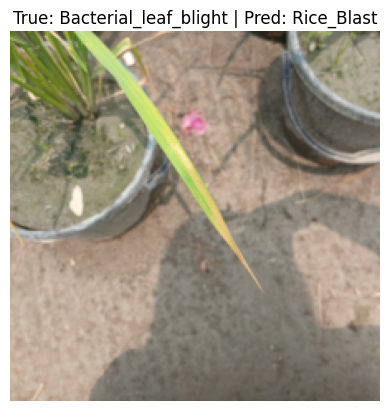

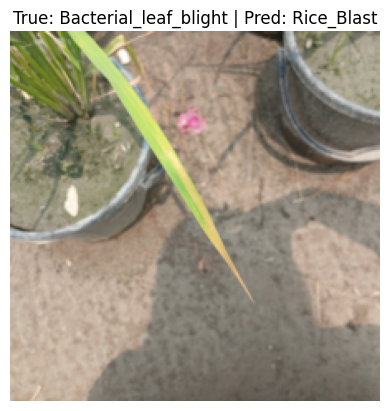

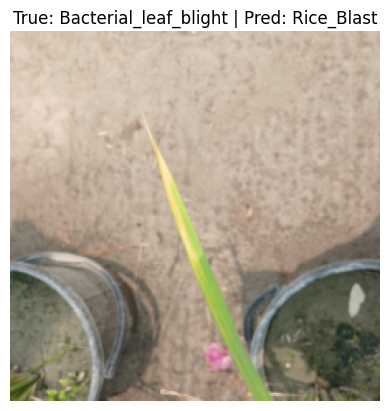

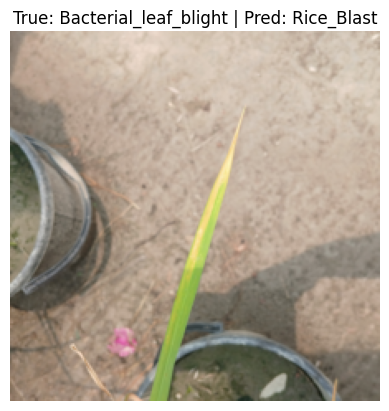

In [18]:
visualize_predictions(custom_model, val_loader, class_names, n=5)

In [19]:
def predict_image(model, image_path, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    plt.imshow(image)
    plt.title(f"Predicted: {class_names[pred.item()]}")
    plt.axis("off")
    plt.show()

# Example: Upload an image in Kaggle notebook
# predict_image(resnet, "/kaggle/input/some_test_image.jpg", val_transforms, class_names)


In [20]:
summary = {
    'Model': ['ResNet50 (Frozen)', 'ResNet50 (Fine-Tuned)', 'EfficientNetB0 (Frozen)', 'EfficientNetB0 (Fine-Tuned)', 'Custom CNN'],
    'Final Accuracy (%)': [
        resnet_history['val_acc'][-1],
        resnet_ft_history['val_acc'][-1],
        effnet_history['val_acc'][-1],
        effnet_ft_history['val_acc'][-1],
        custom_history['val_acc'][-1]
    ]
}

import pandas as pd
results_df = pd.DataFrame(summary)
results_df.sort_values('Final Accuracy (%)', ascending=False).reset_index(drop=True)


,Model,Final Accuracy (%)
0,ResNet50 (Fine-Tuned),100.000000
1,EfficientNetB0 (Fine-Tuned),99.401198
2,EfficientNetB0 (Frozen),97.005988
3,ResNet50 (Frozen),95.808383
4,Custom CNN,54.491018
